# Point Cloud Processing

In [219]:
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  

import math

from random import randrange

Load .ply file

In [220]:
def readPly(filename):
    
    # Using readlines()
    file1 = open(filename, 'r')
    Lines = file1.readlines()
    length = 0

    # Strips the newline character
    for line in Lines:
        length += 1

    num = int(np.floor( (length-11)/2 )+1)

    xyz = np.zeros((num,3), dtype=np.float64)
    rgb = np.zeros((num,3), dtype=np.float64)

    count = 0
    i = 0
    for line in Lines:
        count += 1
        if count > 11:
            point = line.split(' ')

            if count % 2 == 1:
                rgb[i, 0] = int(point[0])/255
                rgb[i, 1] = int(point[1])/255
                rgb[i, 2] = int(point[2])/255

            else:
                xyz[i, 0] = point[0]
                xyz[i, 1] = point[1]
                xyz[i, 2] = point[2]
                i += 1

    return xyz

Select real random point

In [221]:
def randPoint(xyz):

    r,c = np.shape(xyz)
    point = xyz[randrange(r), :]

    while np.isnan(point).any():
            point = xyz[randrange(r), :]

    return point

Surface normal from three points

In [222]:
def surfNorm(xyz):

    U = xyz[1,:] - xyz[0,:]
    V = xyz[2,:] - xyz[0,:]
    
    normal = np.cross(U,V) / LA.norm(np.cross(U,V))

    point = xyz.mean(axis=0)
    
    return normal, point

Random Sample Consensus

In [223]:
def ransac(data, outlierFrac, s, threshold):

        #  number of rows with real entries
        realPoints = sum(~np.isnan(data[:,1]))

        # Stop search when this number has been reached
        T = (1-outlierFrac)*realPoints
        print(T)

        # number of samples needed
        p = 0.99

        # maximum number of loops to run
        N = math.log(1-p) / math.log(1-(1-outlierFrac)**s)
        print(N)
        # Number of points within threshold distance
        num = 0

        i = 0
        while i < N:
                # try a random set points that fits the model
                xyz = np.zeros([s, 3])
     
                j = 0
                while j < s:
                        point = randPoint(data)
  
                        xyz[j,:] = point
                        j += 1


                # find the surface normal of the plane
                [n, point] = surfNorm(xyz)

                dist = np.dot( (data - point), n.T )
                length = abs(dist)

                idx = np.where(length <= threshold)
                count = len(idx[0])

                # save new data
                if count > num:
                        num = count
                        model = np.vstack((n, point))
                        inliers = np.where(length <= threshold)


                #if num >= T:
                #        break
                
                # increment counter
                i += 1
        print(i)
        print(num/realPoints)

        return inliers, model

Surface normal from covariance matrix

In [224]:
def eigNorm(point, radius, xyz):

    # distance from point to all points
    dist = LA.norm(xyz-point, axis=1)

    # points within radius
    points = xyz[dist < radius, :]

    # covariance matrix
    mu = np.mean(points, axis=0)
    pdiff = points - mu
    Sigma = np.dot(pdiff.T, pdiff)

    # eigen vectors and values of covar
    eig, vec = LA.eig(Sigma)

    # smallest eigen value if index of surface normal
    idx = np.where(eig == min(eig))
    normal = vec[:, idx].T

    ratio = min(eig) / max(eig)

    return normal

Read in point cloud

In [225]:
filename = 'points.ply'
filename = 'flat.ply'
#filename = 'tall.ply'
#filename = 'mix.ply'
#filename = 'robot.ply'
#filename = 'robot2.ply'
filename = 'white-flat.ply'
#filename = 'white-angle.ply'
#filename = 'white-tower.ply'

xyz = readPly(filename)
#xyz = xyz[::2, :]

In [226]:
m = np.median(xyz, axis=0)
radius = 0.5
normal = eigNorm(m, radius, xyz)

dist = np.dot( (xyz - m), normal[0].T )
threshold = 0.01
inliers = np.where(abs(dist) < threshold)

gnd = xyz[inliers[0], :]
blocks = np.delete(xyz, inliers[0], 0)

Run RANSAC once to find main surface

In [227]:
'''
outlierFrac = 1 - 0.3
model = 3
threshold = 0.008

inliers, model = ransac(xyz, outlierFrac, model, threshold)
blocks = np.delete(xyz, inliers, 0)

print(model)
'''

'\noutlierFrac = 1 - 0.3\nmodel = 3\nthreshold = 0.008\n\ninliers, model = ransac(xyz, outlierFrac, model, threshold)\nblocks = np.delete(xyz, inliers, 0)\n\nprint(model)\n'

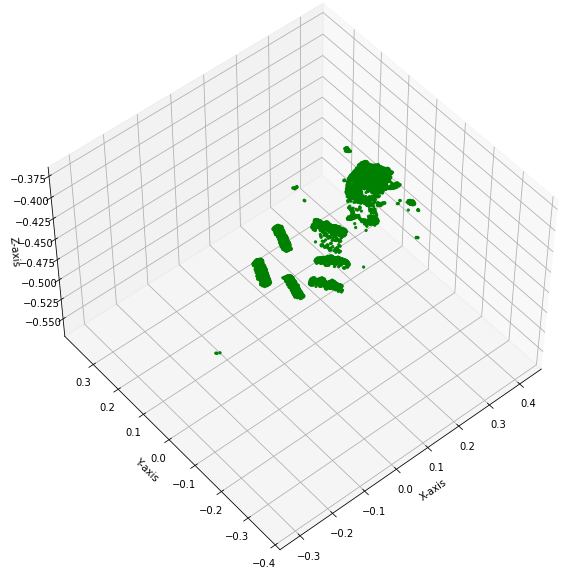

In [236]:
# Create the figure
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Plot the values
spacing = 2
#c = rgb[::spacing,:]

ax.scatter3D(blocks[::5,0], blocks[::5,1], blocks[::5,2], c = 'g', marker='.')
#ax.scatter3D(gnd[::spacing, 0], gnd[::spacing, 1], gnd[::spacing, 2], c = 'k', marker='.')
#ax.scatter3D(xyz[::spacing, 0], xyz[::spacing, 1], xyz[::spacing, 2], c = 'b', marker='.')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

ax.set_xlim3d(m[0]-0.4, m[0]+0.4)
ax.set_ylim3d(m[1]-0.4, m[1]+0.4)
ax.set_zlim3d(m[2]-0.1, m[2]+0.1)

ax.view_init(elev=50, azim=-130)
plt.rcParams['figure.figsize'] = (10,10)

plt.show()